In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from fashion_model import FashionCNN 
from manifold_torch import Manifold_Image_Sampler

from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EXPERIMENT = 'mnist'
RADIUS = 0.00001
NUM_PERTURBATIONS = 100
MULTIPLIER = 100
DIM = 3
PIVOTS = 10
SHUFFLE = False
TARGET = None

print("EXPERIMENT: ", EXPERIMENT)
print("RADIUS: ", RADIUS)
print("TARGET: ", TARGET)
print("DIM: ", DIM)
print("PIVOTS: ", PIVOTS)
print("SHUFFLE: ", SHUFFLE)

EXPERIMENT:  mnist
RADIUS:  1e-05
TARGET:  None
DIM:  3
PIVOTS:  10
SHUFFLE:  False


In [2]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))


Loading mnist
Done loading


In [3]:
start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

if TARGET == None:
    targets = None
    target_str = 'all'
else:
    targets = [TARGET]
    target_str = str(TARGET)

# Get the hyperplanes
_ = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=targets)
manifold_G = manifold_sampler.get_G_from_pivots()
Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

Initialize duration:  235.95174932479858


In [4]:
checkpt_file = 'pretrained/mnistCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/mnistCNN.pt


<All keys matched successfully>

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 

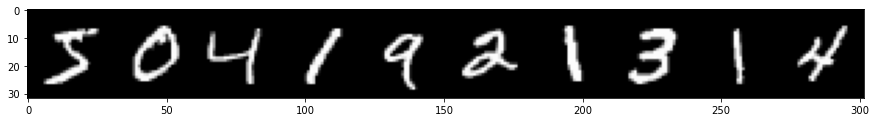

In [5]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(label.item(), end=", ")

In [6]:
# manifold_sampler.pivots.shape

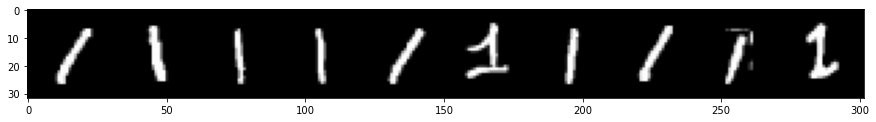

In [7]:
grid = torchvision.utils.make_grid(manifold_sampler.pivots[100:110], nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [8]:
from sklearn import linear_model

# n_samples = 100
sigma = 10
sim_sigma = 4

def similarity_kernel(v1,v2,kernel_width = 1):
    l2_dist = np.linalg.norm(v1 - v2)
    return np.exp(- (l2_dist**2) / (kernel_width**2))

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

In [9]:
DUPLICATIONS = 10
RADIUS = 0.00001
base_RADIUS = 0.0
perturbations = []
for _ in range(DUPLICATIONS):
    # base
    base_gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    r = np.random.uniform()*base_RADIUS
    base_gauss_norm = normalize(base_gauss_, r)
    base_pc = manifold_sampler.to_1d(manifold_sampler.pivots + base_gauss_norm)
    
    # gauss
    gauss_ = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)
    gauss_noise = manifold_sampler.to_1d(gauss_)
    plane_noise = np.zeros_like(gauss_noise)
    for d in range(Gv.shape[0]):
        proj = np.dot(gauss_noise, Gv[d])
        for s in range(plane_noise.shape[0]):
            plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
    ortho_noise = gauss_noise - plane_noise
    
    # noise
    r = np.random.uniform()*RADIUS
    ortho_norm = normalize(ortho_noise, r)
    ortho_pc = base_pc + ortho_norm
    
    perturbations.append(manifold_sampler.to_3d(ortho_pc))
    
perturbations = torch.cat(perturbations)    
perturb_embeded = manifold_sampler.transform(perturbations)

In [10]:
# first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
# probs[:,second_prediction.item()].cpu().detach().numpy()
# probs[:,first_prediction.item()].cpu().detach().numpy()

In [11]:
no_samples, channels, rows, cols = all_images.shape

perturb_outputs = model(perturbations.float().to(device))
probs = nn.functional.softmax(perturb_outputs, dim = 1)

In [12]:
index_to_explain = 600
image_to_explain = manifold_sampler.pivots[index_to_explain]

original_output = model(image_to_explain.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
perturb_1st = probs[:,first_prediction.item()].cpu().detach().numpy()
perturb_2nd = probs[:,second_prediction.item()].cpu().detach().numpy()

In [13]:
base_embeded = manifold_sampler.transform(image_to_explain.unsqueeze(0))
similarities = [similarity_kernel(perturb_embeded[i], base_embeded, kernel_width = 1) for i in range(perturbations.shape[0])]

In [14]:
repeat_shape = (perturbations.shape[0],) + tuple(np.ones(image_to_explain.ndim). astype(int))
repeat_image_to_explain = image_to_explain.repeat(repeat_shape)
true_perturb = perturbations - repeat_image_to_explain

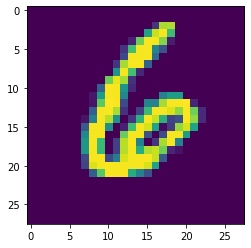

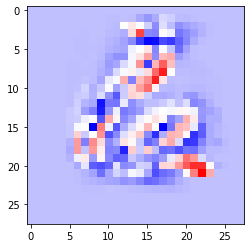

In [15]:
clf = linear_model.Ridge(alpha = 200)
clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_1st, sample_weight=similarities)
explanation_1st = clf.coef_.reshape(rows, cols)
# clf.fit(np.abs(true_perturb).reshape(true_perturb.shape[0], channels*rows*cols), perturb_2nd, sample_weight=similarities)
# explanation_2nd = -clf.coef_.reshape(rows, cols)

plt.figure()
plt.imshow(image_to_explain[0])
plt.figure()
plt.imshow(-explanation_1st, cmap=plt.get_cmap('bwr'))

# plt.figure()
# plt.imshow(explanation_2nd, cmap=plt.get_cmap('seismic'))

In [16]:
# explanation_diff = explanation_1st - explanation_2nd

# plt.figure()
# plt.imshow(explanation_diff, cmap=plt.get_cmap('seismic'))

In [17]:
image_to_explain_grad = Variable(image_to_explain, requires_grad=True)
original_output = model(image_to_explain_grad.unsqueeze(0).to(device))
first_prediction, second_prediction = torch.topk(original_output, 2)[1][0]
original_output[0,first_prediction].backward()
image_grad = image_to_explain_grad.grad
grad_sq = normalize(image_grad.detach().numpy()**2,1)[0]
expl_sq = explanation_1st**2
expl_np = normalize(expl_sq - np.min(expl_sq),1)
sensitivity_score = np.inner(grad_sq.reshape(28*28),expl_np.reshape(28*28))

In [18]:
first_prediction

tensor(6, device='cuda:0')

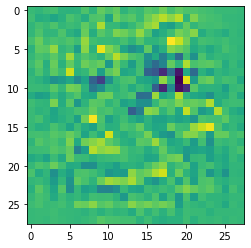

In [19]:
plt.imshow(image_grad[0])

In [20]:
sensitivity_score

0.2159513537021771

In [52]:
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum.metrics._core.infidelity import infidelity
from captum.metrics._core.sensitivity import sensitivity_max

In [44]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=sim_sigma)
lr_lime = Lime(model, 
              interpretable_model=SkLearnLinearRegression(), 
              similarity_func=exp_eucl_distance,
              perturb_func = None)

def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float().to(device)
    return noise, inputs - noise

In [40]:
lime_1st = lr_lime.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=200,
            perturbations_per_eval=16,
            show_progress=False
        )

In [48]:
infid = infidelity(model.to(device), perturb_fn, image_to_explain.unsqueeze(0).to(device), lime_1st.to(device), target=first_prediction)

In [68]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import Occlusion
from captum.attr import Lime
from captum.attr import DeepLiftShap
from captum.attr import visualization as viz

occlusion = Occlusion(model)

In [69]:
sens = sensitivity_max(explanation_func = Occlusion.attribute,
                    inputs = image_to_explain.unsqueeze(0).to(device),
                    target=first_prediction)

TypeError: attribute() missing 2 required positional arguments: 'inputs' and 'sliding_window_shapes'

In [33]:
def gen_mask(score, ones_ratio = 0.2):
    no_rows, no_cols = score.shape
    score_flat = np.reshape(score, no_rows*no_cols)
    top_k = int(ones_ratio*no_rows*no_cols)
    idx = np.argpartition(score_flat, -top_k)[-top_k:]
    indices = idx[np.argsort((-score_flat)[idx])]
    score_flat_dup = np.zeros_like(score_flat)
    score_flat_dup[indices] = 1.0
    score_dup = score_flat_dup.reshape(no_rows, no_cols)
    return score_dup

lime_1st = lr_lime.attribute(
            image_to_explain.unsqueeze(0).to(device),
            target=first_prediction,
            n_samples=200,
            perturbations_per_eval=16,
            show_progress=False
        ).squeeze(0).cpu().detach().numpy()[0]

lime_2nd = lr_lime.attribute(
    image_to_explain.unsqueeze(0).to(device),
    target=second_prediction,
    n_samples=200,
    perturbations_per_eval=16,
    show_progress=False
).squeeze(0).cpu().detach().numpy()[0]

modified_image_lime = image_to_explain.clone().numpy()
modified_mask_lime = gen_mask(lime_1st - lime_2nd)
modified_image_lime[0][modified_mask_lime==1] = 1 - modified_image_lime[0][modified_mask_lime==1]
modified_image_lime = torch.tensor(modified_image_lime)
modified_output_lime = model(modified_image_lime.unsqueeze(0).to(device))
modified_prob_lime = nn.functional.softmax(modified_output_lime, dim = 1)

original_output = model(image_to_explain.unsqueeze(0).to(device))
original_prob = nn.functional.softmax(original_output, dim = 1)
original_log_odds = np.log(original_prob[0][first_prediction].cpu().detach().numpy()/original_prob[0][second_prediction].cpu().detach().numpy())
modified_log_odds_lime = np.log(modified_prob_lime[0][first_prediction].cpu().detach().numpy()/modified_prob_lime[0][second_prediction].cpu().detach().numpy())
log_odds_score_lime = original_log_odds - modified_log_odds_lime

RuntimeError: CUDA error: device-side assert triggered

In [19]:
print(log_odds_score_lime)

15.696755


In [41]:
lime_np = normalize(lime_1st**2 - np.min(lime_1st**2),1)
sensitivity_score_lime = np.inner(grad_sq.reshape(28*28),lime_np.reshape(28*28))

In [42]:
sensitivity_score_lime

0.18821463

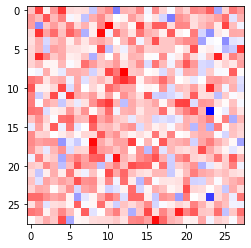

In [47]:
plt.imshow(lime_1st, cmap=plt.get_cmap('bwr'))

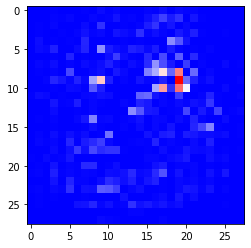

In [48]:
plt.imshow(grad_sq, cmap=plt.get_cmap('bwr'))
